In [11]:
%matplotlib inline
from Chapter5.DistanceMetrics import InstanceDistanceMetrics
from Chapter5.DistanceMetrics import PersonDistanceMetricsNoOrdering
from Chapter5.DistanceMetrics import PersonDistanceMetricsOrdering
from Chapter5.Clustering import NonHierarchicalClustering
from Chapter5.Clustering import HierarchicalClustering
from util.VisualizeDataset import VisualizeDataset
from IPython.display import display
from scipy.cluster.hierarchy import dendrogram

import util.util as util
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os


plt.rcParams['figure.dpi'] = 100



In [3]:
def plot_xy(x, y, method='plot', xlabel=None, ylabel=None, xlim=None, ylim=None, names=None,
            line_styles=None, loc=None, title=None):
    for input in x, y:
        if not hasattr(input[0], '__iter__'):
            raise TypeError('x/y should be given as a list of lists of coordinates')

    plot_method = getattr(plt, method)
    for i, (x_line, y_line) in enumerate(zip(x, y)):

        plot_method(x_line, y_line, line_styles[i]) if line_styles is not None else plt.plot(x_line, y_line)

        if xlabel is not None: plt.xlabel(xlabel)
        if ylabel is not None: plt.ylabel(ylabel)
        if xlim is not None: plt.xlim(xlim)
        if ylim is not None: plt.ylim(ylim)
        if title is not None: plt.title(title)
        if names is not None: plt.legend(names)


    plt.figure()


In [4]:
def plot_clusters_3d(data_table, data_cols, cluster_col, label_cols,title=''):

    color_index = 0
    point_displays = ['+', 'x', '*', 'd', 'o', 's', '<', '>']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # Determine the number of clusters:
    
    clusters = data_table[cluster_col].unique()
    
    labels = []

    # Get the possible labels, assuming 1 or more label columns with binary values.
    for i in range(0, len(label_cols)):
        labels.extend([name for name in list(data_table.columns) if label_cols[i] == name[0:len(label_cols[i])]])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    handles = []

    # Plot clusters individually with a certain color.
    for cluster in clusters:
        marker_index = 0
        # And make sure the points of a label receive the right marker type.
        for label in labels:
            rows = data_table.loc[(data_table[cluster_col] == cluster) & (data_table[label] > 0)]
            # Now we come to the assumption that there are three data_cols specified:
            if not len(data_cols) == 3:
                return
            plot_color = colors[color_index%len(colors)]
            plot_marker = point_displays[marker_index%len(point_displays)]
            pt = ax.scatter(rows[data_cols[0]], rows[data_cols[1]], rows[data_cols[2]], c=plot_color, marker=plot_marker)
            if color_index == 0:
                handles.append(pt)
            ax.set_xlabel(data_cols[0])
            ax.set_ylabel(data_cols[1])
            ax.set_zlabel(data_cols[2])
            marker_index += 1
        color_index += 1

    plt.legend(handles, labels, fontsize='xx-small', numpoints=1)
    if title is not None: plt.title(title)
    # plt.show()
    plt.figure()

In [12]:
def plot_dendrogram(dataset, linkage):
    sys.setrecursionlimit(40000)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('time points')
    plt.ylabel('distance')
    times = dataset.index.strftime('%H:%M:%S')
    #dendrogram(linkage,truncate_mode='lastp',p=10, show_leaf_counts=True, leaf_rotation=90.,leaf_font_size=12.,show_contracted=True, labels=times)
    dendrogram(linkage,truncate_mode='lastp',p=16, show_leaf_counts=True, leaf_rotation=45.,leaf_font_size=8.,show_contracted=True, labels=times)
    
    plt.figure()

In [ ]:
def plot_silhouette(data_table, cluster_col, silhouette_col):
    # Taken from the examples of scikit learn
    #(http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

    clusters = data_table[cluster_col].unique()

    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    #ax1.set_ylim([0, len(data_table.index) + (len(clusters) + 1) * 10])
    y_lower = 10
    for i in range(0, len(clusters)):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        rows = data_table.mask(data_table[cluster_col] != clusters[i])
        ith_cluster_silhouette_values = np.array(rows[silhouette_col])
        ith_cluster_silhouette_values.sort()

        size_cluster_i = len(rows.index)
        y_upper = y_lower + size_cluster_i

        color = plt.get_cmap('Spectral')(float(i) / len(clusters))
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=data_table[silhouette_col].mean(), color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    figure
    plt.show()

In [5]:
# As usual, we set our program constants, read the input file and initialize a visualization object.
DATA_PATH = Path('./intermediate_datafiles/')
DATASET_FNAME = 'chapter4_result.csv'
# RESULT_FNAME = 'chapter5_result.csv'
figure_path = os.path.abspath('figures/ch_5_1')


try:
    dataset = pd.read_csv(DATA_PATH / DATASET_FNAME, index_col=0)
    dataset.index = pd.to_datetime(dataset.index)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

# DataViz = VisualizeDataset(figure_path)

clusteringNH = NonHierarchicalClustering()
clusteringH = HierarchicalClustering()

### K-MEANS


===== kmeans clustering =====
Highest K-Means silhouette score: k =  9


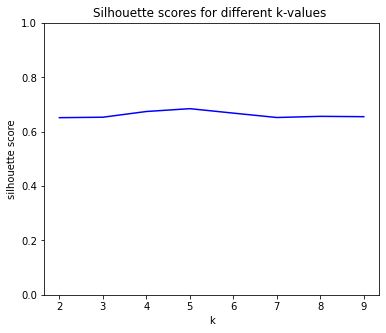

<Figure size 432x360 with 0 Axes>

In [8]:
%matplotlib inline
# Let us look at k-means first.
plt.rcParams['figure.figsize'] = [6, 5]
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for k

print('===== kmeans clustering =====')
for k in k_values:
    dataset = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k, 'default', 20, 10)
    silhouette_score = dataset['silhouette'].mean()
    silhouette_values.append(silhouette_score)

# DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'],title= '')
plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'],title= 'Silhouette scores for different k-values ')

# And run the knn with the highest silhouette score

k_kmean = k_values[np.argmax(silhouette_values)]
print('Highest K-Means silhouette score: k = ',k)


\multirow{2}{*}{ gyr_phone_x } & mean  &  -0.01 &  0.80 &  -0.91 &  1.17 &  -1.09\\
 & std  &  0.15 &  0.43 &  0.39 &  0.42 &  0.43\\
\multirow{2}{*}{ gyr_phone_y } & mean  &  0.04 &  -0.37 &  -0.14 &  0.31 &  0.16\\
 & std  &  0.22 &  0.59 &  0.51 &  0.56 &  0.58\\
\multirow{2}{*}{ gyr_phone_z } & mean  &  0.01 &  -0.50 &  -0.83 &  1.02 &  0.80\\
 & std  &  0.12 &  0.47 &  0.41 &  0.47 &  0.33\\
labelOnTable  & percentage  &  100.00 \% &  0.00 \% &  0.00 \% &  0.00 \% &  0.00 \%\\
labelSitting  & percentage  &  98.80 \% &  0.00 \% &  0.80 \% &  0.40 \% &  0.00 \%\\
labelWashingHands  & percentage  &  91.23 \% &  1.75 \% &  5.26 \% &  1.75 \% &  0.00 \%\\
labelWalking  & percentage  &  28.57 \% &  21.31 \% &  18.50 \% &  15.46 \% &  16.16 \%\\
labelStanding  & percentage  &  96.21 \% &  1.42 \% &  0.47 \% &  0.47 \% &  1.42 \%\\
labelDriving  & percentage  &  98.06 \% &  0.56 \% &  0.28 \% &  0.00 \% &  1.11 \%\\
labelEating  & percentage  &  97.46 \% &  1.02 \% &  0.51 \% &  0.51 \% &

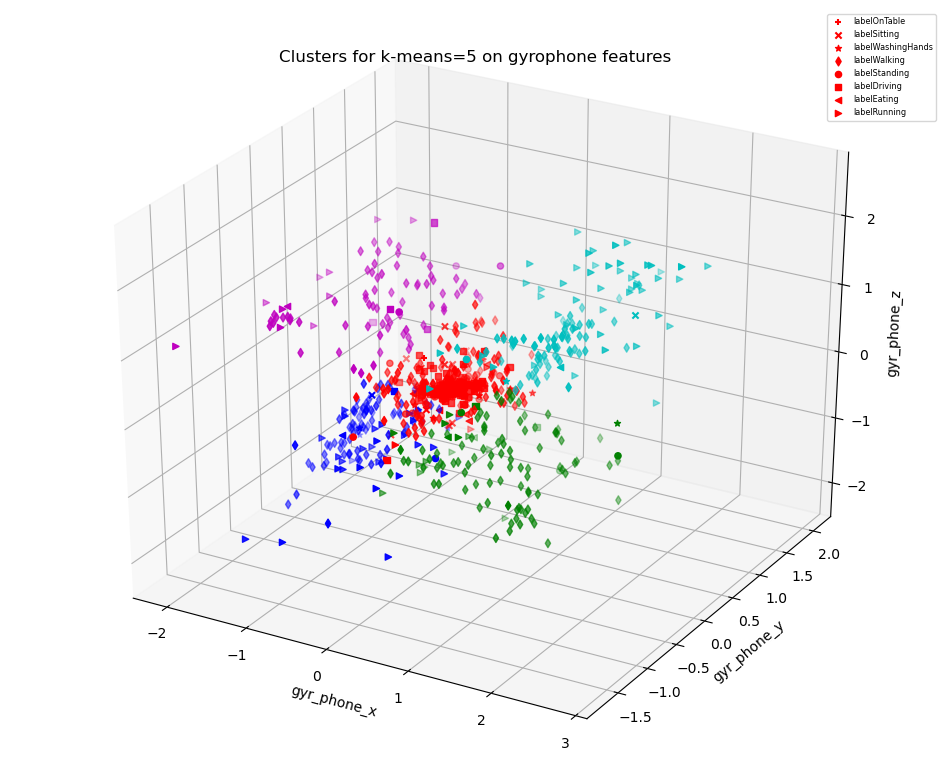

<Figure size 1200x1000 with 0 Axes>

In [126]:
plt.rcParams['figure.figsize'] = [12, 10]

dataset = clusteringNH.k_means_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k_kmean, 'default', 20, 10)
plot_clusters_3d(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'cluster', ['label'],title='Clusters for k-means=5 on gyrophone features')

util.print_latex_statistics_clusters(dataset, 'cluster', ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'label')
# del dataset['silhouette']
DataViz.plot_silhouette(dataset, 'cluster', 'silhouette')

## K-MEDOIDS

===== k medoids clustering =====
k = 2
silhouette = 0.6689559033160772
k = 3
silhouette = 0.6430848222845346
k = 4
silhouette = 0.60647912161394
k = 5
silhouette = 0.6564067139668597
k = 6
silhouette = 0.6369365219630738
k = 7
silhouette = 0.6252917317521491
k = 8
silhouette = 0.6124863523552019
k = 9
silhouette = 0.6191899848574837
Highest K-Medoids silhouette score: k = 2


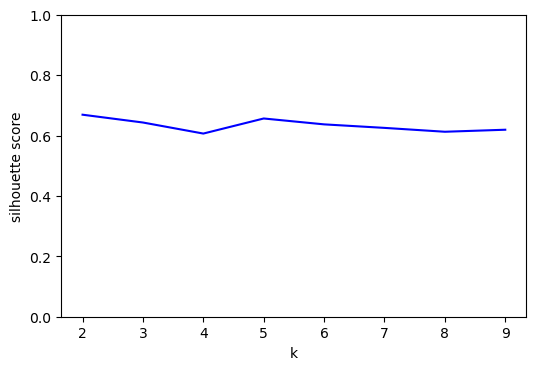

<Figure size 600x400 with 0 Axes>

In [17]:
# Do some initial runs to determine the right number for k
k_values = range(2, 10)
silhouette_values = []
print('===== k medoids clustering =====')

for k in k_values:
    print(f'k = {k}')
    dataset_cluster = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k, 'default', 20, n_inits=10)
    silhouette_score = dataset_cluster['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)

plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score', ylim=[0, 1], line_styles=['b-'])

# And run k medoids with the highest silhouette score
k_kmedoids = k_values[np.argmax(silhouette_values)]
print(f'Highest K-Medoids silhouette score: k = {k_kmedoids}')



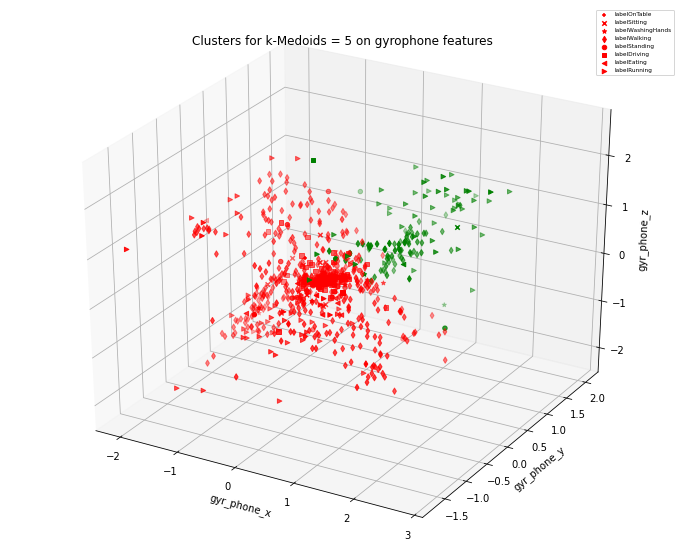

<Figure size 864x720 with 0 Axes>

In [10]:
plt.rcParams['figure.figsize'] = [12, 10]
dataset_kmed = clusteringNH.k_medoids_over_instances(copy.deepcopy(dataset), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k_kmedoids, 'default', 20, n_inits=50)
plot_clusters_3d(copy.deepcopy(dataset_kmed), ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'cluster', ['label'],title='Clusters for k-Medoids = 5 on gyrophone features')

# util.print_latex_statistics_clusters(dataset_kmed, 'cluster', ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], 'label')

===== agglomerative clustering =====
k = 2
silhouette = 0.6676832244147272
k = 3
silhouette = 0.6623398255090625
k = 4
silhouette = 0.6744328097767218
k = 5
silhouette = 0.6855873627560741
k = 6
silhouette = 0.6038108797686378
k = 7
silhouette = 0.6002214412293708
k = 8
silhouette = 0.6002559752038582
k = 9
silhouette = 0.6003549065297363


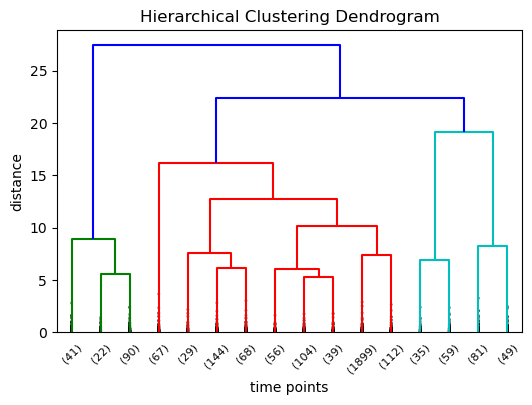

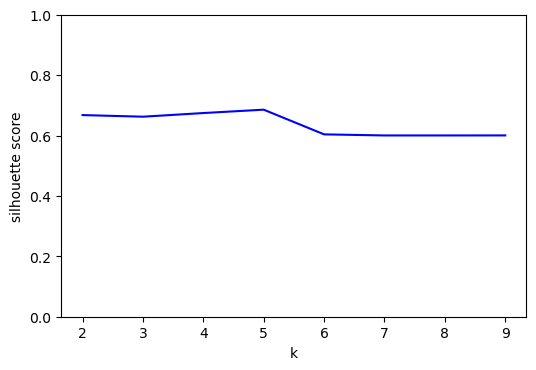

<Figure size 600x400 with 0 Axes>

In [18]:
k_values = range(2, 10)
silhouette_values = []

# Do some initial runs to determine the right number for the maximum number of clusters.

print('===== agglomerative clustering =====')
for k in k_values:
    print(f'k = {k}')
    dataset, l = clusteringH.agglomerative_over_instances(dataset, ['gyr_phone_x', 'gyr_phone_y', 'gyr_phone_z'], k, 'euclidean', use_prev_linkage=True, link_function='ward')
    silhouette_score = dataset['silhouette'].mean()
    print(f'silhouette = {silhouette_score}')
    silhouette_values.append(silhouette_score)
    
    if k == k_values[0]:
        plot_dendrogram(dataset, l)


plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
                ylim=[0, 1], line_styles=['b-'])

In [14]:
k_values[0]

2